In [1]:
import pandas as pd
import numpy as np
import zipfile
from copy import deepcopy
from collections import defaultdict
from savReaderWriter import SavReader
from savReaderWriter import SavHeaderReader

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [131]:
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.dummy import DummyClassifier

In [85]:
# Initializing a list of colors for plotting later on
colors_for_plots = ['firebrick','darkgreen','blue','mediumvioletred','darkorchid','black','orangered','dodgerblue','darkolivegreen','magenta']
colors_for_plots_2 = ['indianred','mediumseagreen','royalblue','violet','plum','dimgray','darkorange','lightskyblue','olivedrab','hotpink']

The raw data can be found on the [PEW Website](http://www.pewglobal.org/2014/06/05/spring-2014-survey-data/)

In [6]:
#extractin the zip file and convertin the .sav file into a pandas dataframe
pew_zip_path = '/home/farhaan/Downloads/pew-global-14-questions.zip'
zf = zipfile.ZipFile(pew_zip_path)
zf.extract('Pew Research Global Attitudes Spring 2014 Dataset for web.sav',path='/home/farhaan/ds/metis/metisgh/Test_box/03_Rough_folder/')

df_raw= pd.DataFrame(list(SavReader('/home/farhaan/ds/metis/metisgh/Test_box/03_Rough_folder/Pew Research Global Attitudes Spring 2014 Dataset for web.sav')))

In [9]:
#pickling file for future use
#df_raw.to_pickle('/home/farhaan/ds/metis/metisgh/Test_box/03_Rough_folder/raw_data_df.p')

In [7]:
#Have a HUGE dataset with 1150 columns and 48643 original entries
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48643 entries, 0 to 48642
Columns: 1150 entries, 0 to 1149
dtypes: float64(1087), object(63)
memory usage: 426.8+ MB


In [10]:
# The original column names are of no use to us since we have no idea
# what it condains if it just have a column index value as the label
df_raw.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149
18436,118499.0,43.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,b'U',2.0,1.0,1.0,1.0,1.678357,43001.0,43001.0
34022,134112.0,38.0,1.0,7.0,NaN,8.0,9.0,8.0,9.0,3.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,0.926104,38064.0,38032.0
28248,128338.0,13.0,1.0,5.0,NaN,7.0,5.0,5.0,9.0,6.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,0.241840,13105.0,13009.0
43742,143832.0,2.0,2.0,6.0,NaN,4.0,8.0,8.0,7.0,8.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,0.805023,2108.0,2004.0
47384,147525.0,11.0,1.0,4.0,NaN,5.0,98.0,4.0,5.0,9.0,...,NaN,NaN,b'',NaN,NaN,NaN,NaN,0.856112,11086.0,11007.0


In [11]:
#Trying to read and decipher the .sav file headers
with SavHeaderReader('/home/farhaan/ds/metis/metisgh/Test_box/03_Rough_folder/Pew Research Global Attitudes Spring 2014 Dataset for web.sav') as header:
    metadata = header.all()
    print(metadata.varLabels)

{b'PSRAID': b'PSRAI ID', b'COUNTRY': b'Country', b'Q1': b'Q1. To begin, how would you describe your day today\xe2\x80\x94has it been a typical day, a particularly good day, or a particularly bad day? ', b'Q2A': b"Q2A. Here is the 'ladder of life' The top of the ladder represents the best possible life for you; and the bottom, the worst possible life for you.  On which step of the ladder do you feel you personally stand at the present time?", b'Q2B': b'Q2B. Imagine a ladder with steps numbered from 0 at the bottom to 10 at the top.  The top represents the best possible life for you; the bottom, the worst possible life.  On which step do you feel you personally stand at present time?', b'Q3A': b'Q3A. On which step would you say you stood five years ago?  ', b'Q3B': b'Q3B. Just your best guess, on which step do you think you will stand in the future, say five years from now?', b'Q4A': b'Q4A. On a scale of 0 to 10 how satisfied are you with each of the following items, where 0 means you ar

After a fair amount of time spent comparing the original pew questionnaire and the above metadata jumble,
Turns out the metadata contains information about the questions in the survey such as: full question, answer options, etc.
Notably the length of the first element of the metadata is the same as the number of columns in the raw dataframe.
Coincidence? I think not!

In [12]:
#Getting a list of all the Question names so that the columns may be renamed
# The question names are in byte format so I am 'decode'-ing them to read as utf-8 strings
q_names_all = []
for ind , qname in enumerate(list(metadata)[0]):
    q_names_all.append(qname.decode())

#Let's go ahead and rename the columns of the raw dataframe for readability    
df_raw.columns = q_names_all

In [13]:
# I want to create an easily queriable dictionary with full survey question
# wording and possible responses
q_full_dict = defaultdict(dict)
for key,value in list(metadata)[3].items():
    q_full_dict[key.decode()]=value

    
q_responses_dict = defaultdict(dict)
for key,value in list(metadata)[2].items():
    q_responses_dict[key.decode()]=value

# Super-basic data-cleaning

In [14]:
#A quick info method on the raw dataframe shows that we have a fair number of dtype "objects"
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48643 entries, 0 to 48642
Columns: 1150 entries, PSRAID to stratum
dtypes: float64(1087), object(63)
memory usage: 426.8+ MB


In [15]:
#Cross-referencing these with the survey question codes shows that
#these are not questions of interest for this project
#thus we will create a new dataframe that excludes these columns
print("List of excluded columns\n",list(df_raw.select_dtypes(include=[object]).columns))

non_object_cols_df = df_raw.select_dtypes(exclude=[object])

List of excluded columns
 ['QRELARGA', 'QRELBANA', 'QRELBANB', 'QRELBRAB', 'QRELBRIA', 'QRELCHIA', 'QRELCOLA', 'QRELEGYA', 'QRELEGYB', 'QRELESAA', 'QRELFRAA', 'QRELGERA', 'QRELGHAA', 'QRELGREA', 'QRELINDB', 'QRELINDOB', 'QRELISRA', 'QRELISRB', 'QRELIITAA', 'QRELJPNA', 'QRELJPNB', 'QRELJORA', 'QRELJORB', 'QRELKENA', 'QRELLEBA', 'QRELLEBB', 'QRELMALA', 'QRELMALB', 'QRELMEXA', 'QRELNICA', 'QRELNIGA', 'QRELPAKA', 'QRELPAKB', 'QRELPALA', 'QRELPALB', 'QRELPERA', 'QRELPHIA', 'QRELPOLA', 'QRELRUSA', 'QRELSENA', 'QRELSENB', 'QRELRSAa', 'QRELSPAA', 'QRELTANA', 'QRELTUNB', 'QRELTURA', 'QRELTURB', 'QRELUGAA', 'QRELUSA', 'QRELUKRB', 'QRELVENB', 'QRELVIEA', 'QRELVIEB', 'Q96A_1OTH', 'Q96A_2OTH', 'Q96A_3OTH', 'Q96B_1OTH', 'Q96B_2OTH', 'Q96B_3OTH', 'Q138BPHI', 'RACE3M4', 'RACEOS', 'USR']


## Attention!

Q2A and Q2B are a measure of the target dependent variables:
An indicator of how satisfied people are with their life.


They are esentially, the same question but one (Q2A) is for people
interviewed in person whereas (Q2B) is for people that were
interviewed over the phone.
- Note there are a lot more people who did in-person interviews than phone interviews

In [25]:
print(f'Face-to-face non-null Interview responses to Q2: {non_object_cols_df.loc[:,["Q2A"]].notnull().sum()[0]}')
print(f'Telephone non-null Interview responses to Q2: {non_object_cols_df.loc[:,["Q2B"]].notnull().sum()[0]}')

Face-to-face non-null Interview responses to Q2: 40620
Telephone non-null Interview responses to Q2: 7023


In [16]:
non_object_cols_df.loc[:,['Q2A','Q2B']].sample(15,random_state=40)

,Q2A,Q2B
21683,8.0,NaN
1516,NaN,8.0
30540,5.0,NaN
21385,6.0,NaN
28072,5.0,NaN
1295,NaN,8.0
31490,6.0,NaN
8597,10.0,NaN
10399,5.0,NaN
47992,8.0,NaN


In order to accurately analyze this data,
we need a column that contains the responses of Q2A AND Q2B,
whichever one was used to find out the target response.
So, let's create a new column 'Q2agg' with just that information.
And then drop any rows that still have NaN values for 'Q2Agg'

In [26]:
choice_columns=['Q2A, Q2B']
def pick_cell_with_notnull_value(row):
    if pd.notnull(row['Q2A']):
        return row['Q2A']
    elif pd.notnull(row['Q2B']):
        return row['Q2B']
    else:
        return None

non_object_cols_df['Q2agg']=non_object_cols_df.apply(pick_cell_with_notnull_value,axis=1)
non_object_cols_df=non_object_cols_df.dropna(axis=0,subset=['Q2agg'])
#also remove 98 "Don't know" and 99 Refused"  values from dataset
non_object_cols_df = non_object_cols_df[non_object_cols_df['Q2agg']<=10]

/home/farhaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Unfortunately, a lot of the data columns have information that were country-specific or didn't contain data that might be 'useful' in creating a model.

So, I'm removing those questions, and focusing on a select questions on which to perform analysis.

In [28]:
#Selecting columns of interest to be used in analysis
desired_cols= ['Q2agg','Q5','Q9','Q10','Q11','Q13A','Q13B','Q23A','Q23B','Q23C','Q23D',
               'Q27','Q28','Q30','Q66A','Q66B','Q66C','Q66D','Q66E','Q66F','Q66G',
               'Q77','Q77B','Q132','Q140','Q153']

desired_cols_df = non_object_cols_df[desired_cols]

In [363]:
#Much lesser memory usage since so many columns were dropped!
desired_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47418 entries, 0 to 48642
Data columns (total 25 columns):
Q2agg    47418 non-null float64
Q5       47418 non-null float64
Q9       47418 non-null float64
Q10      47418 non-null float64
Q11      47418 non-null float64
Q13A     47418 non-null float64
Q13B     47418 non-null float64
Q23A     47418 non-null float64
Q23B     47418 non-null float64
Q23C     47418 non-null float64
Q23D     47418 non-null float64
Q27      47418 non-null float64
Q28      47418 non-null float64
Q30      47418 non-null float64
Q66A     47418 non-null float64
Q66B     47418 non-null float64
Q66C     47418 non-null float64
Q66D     47418 non-null float64
Q66E     47418 non-null float64
Q66F     47418 non-null float64
Q66G     47418 non-null float64
Q77B     47418 non-null float64
Q132     47418 non-null float64
Q140     47418 non-null float64
Q153     47418 non-null float64
dtypes: float64(25)
memory usage: 9.4 MB


In [29]:
#Cleaning rows where respondent of refusal to answer questions
cleaned_df = deepcopy(desired_cols_df)
cleaned_df = cleaned_df[cleaned_df['Q5']!=9]
cleaned_df = cleaned_df[cleaned_df['Q13A']!=9]
cleaned_df = cleaned_df[cleaned_df['Q13B']!=9]
cleaned_df = cleaned_df[cleaned_df['Q23A']!=9]
cleaned_df = cleaned_df[cleaned_df['Q23B']!=9]
cleaned_df = cleaned_df[cleaned_df['Q23C']!=9]
cleaned_df = cleaned_df[cleaned_df['Q23D']!=9]
cleaned_df = cleaned_df[cleaned_df['Q27']!=9]
cleaned_df = cleaned_df[cleaned_df['Q28']!=9]
cleaned_df = cleaned_df[cleaned_df['Q30']!=9]
cleaned_df = cleaned_df[cleaned_df['Q66A']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66B']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66C']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66D']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66E']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66F']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66G']!=98]
cleaned_df = cleaned_df[cleaned_df['Q66A']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66B']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66C']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66D']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66E']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66F']!=99]
cleaned_df = cleaned_df[cleaned_df['Q66G']!=99]
cleaned_df = cleaned_df[cleaned_df['Q153']!=8]
cleaned_df = cleaned_df[cleaned_df['Q153']!=9]

In [31]:
#After cleaning, the data has shrunk slightly from ~47400 to ~44100
cleaned_df.shape

(44080, 26)

In [34]:
# The distribution of the satisfaction ratings where 10 is the highest and 0 is the lowest is as such:
cleaned_df['Q2agg'].value_counts()

7.0     8460
5.0     8174
8.0     7279
6.0     6907
4.0     3336
9.0     2799
10.0    2743
3.0     2149
2.0     1092
1.0      590
0.0      551
Name: Q2agg, dtype: int64

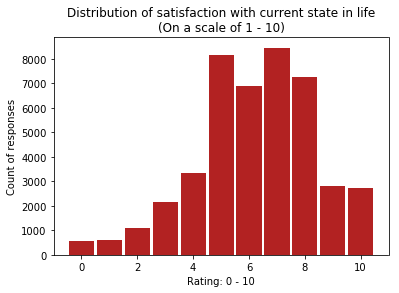

In [35]:
#This is the distribution of numerical satisfaction ratings
plt.hist(cleaned_df.loc[:,'Q2agg'],bins=11,range=(0,11),align='left',color=colors_for_plots[0],rwidth=0.9)
plt.title("Distribution of satisfaction with current state in life\n(On a scale of 1 - 10)")
plt.xlabel("Rating: 0 - 10")
plt.ylabel("Count of responses")

**Separation into classes**

It seems like around half the population had ratings between 0 and 6 and another half had rating between 7 and 10.
Arguably, this boundary can serve as a means to distinguish between respondents that were *Satisfied* with their perceived position on the 'ladder of life' and those that were *Dissatisfied*.

In [36]:
#giving a satisfaction rating of Satisfied/Unsatisfied based on answer to Q2 ('Q2agg')
def satisfaction_rating(row):
    # Q2agg of 7 or higher
    if row['Q2agg']>=7:
        return "Satisfied"
    # Q2agg of 0-6
    else:
        return "Dissatisfied"
    
cleaned_df['satisfaction_rating']=cleaned_df.apply(satisfaction_rating,axis=1)

In [52]:
sat_dissat_split = pd.Series(cleaned_df.iloc[:,-1].value_counts(normalize=True))
print(f'Respondents that were {sat_dissat_split.index[0]} with their current lot in life: {str(sat_dissat_split[0]*100)[0:4]}%')
print(f'Respondents that were {sat_dissat_split.index[1]} with their current lot in life: {str(sat_dissat_split[1]*100)[0:4]}%')

Respondents that were Dissatisfied with their current lot in life: 51.7%
Respondents that were Satisfied with their current lot in life: 48.2%


In [54]:
cleaned_df.sample(5,random_state=40)

,Q2agg,Q5,Q9,Q10,Q11,Q13A,Q13B,Q23A,Q23B,Q23C,...,Q66D,Q66E,Q66F,Q66G,Q77,Q77B,Q132,Q140,Q153,satisfaction_rating
12921,5.0,2.0,4.0,3.0,2.0,3.0,8.0,1.0,1.0,2.0,...,0.0,10.0,0.0,10.0,8.0,8.0,2.0,7.0,1.0,Dissatisfied
8548,5.0,2.0,4.0,4.0,2.0,8.0,2.0,1.0,1.0,1.0,...,8.0,7.0,3.0,10.0,3.0,3.0,1.0,2.0,6.0,Dissatisfied
23096,8.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,...,5.0,10.0,10.0,10.0,6.0,2.0,1.0,1.0,1.0,Satisfied
36439,7.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,4.0,1.0,1.0,3.0,6.0,Satisfied
35480,8.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,...,8.0,9.0,8.0,10.0,3.0,2.0,2.0,1.0,1.0,Satisfied


### Generating Clean data sets for initial analysis (before creating Dummy Variables)

In [55]:
# X and y to be inputted into models
X= cleaned_df.iloc[:,1:-1]
y= cleaned_df.iloc[:,-1]

In [56]:
#will be using this extensively as the cross-validation set
cross_validator= KFold(n_splits=10, shuffle=True, random_state=40)

In [90]:
#A Dictionary containing the names of all the models
model_str_dict = {'dummy':"Always Guess\nDissatisfied",'decision':"Decision\nTree",'knn':"k Nearest\nNeighbors",'randomf':"Random\nForest",'logr':"Logistic\nRegression"}

In [92]:
model_scores_list=[]

#The Baseline Dummy Classifier Model - Everyone is dissatisfied
dummyclassifiermodel = DummyClassifier(strategy='most_frequent',random_state=40)
dummy_score = cross_val_score(dummyclassifiermodel,X,y,cv=cross_validator).mean()
print(f"Score of DummyClassifier Model = {dummy_score}")
model_scores_list.append((model_str_dict['dummy'],dummy_score))

#Decision Tree Classifier Model
decisiontree = DecisionTreeClassifier(random_state=40)
decisiontree_score = cross_val_score(decisiontree,X,y,cv=cross_validator).mean()
print(f"Score of Decision Tree Model = {decisiontree_score}")
model_scores_list.append((model_str_dict['decision'],decisiontree_score))

#Random Forest Classifier Model
randomforest = RandomForestClassifier(random_state=40,n_jobs=-1)
randomforest_score = cross_val_score(randomforest,X,y,cv=cross_validator).mean()
print(f"Score of Random Forest Model = {randomforest_score}")
model_scores_list.append((model_str_dict['randomf'],randomforest_score))

#Logistic Regression Classifier Model
logregression = LogisticRegression(random_state=40,n_jobs=-1)
logregression_score = cross_val_score(logregression,X,y,cv=cross_validator).mean()
print(f"Score of Logistic Regression Model = {logregression_score}")
model_scores_list.append((model_str_dict['logr'],logregression_score))

#K Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_score = cross_val_score(knn,X,y,cv=cross_validator).mean()
print(f"Score of KNN Model = {knn_score}")
model_scores_list.append((model_str_dict['knn'],knn_score))

Score of DummyClassifier Model = 0.5172186932849364
Score of Decision Tree Model = 0.5456442831215971
Score of Random Forest Model = 0.5796052631578948
Score of Logistic Regression Model = 0.6000453720508168
Score of KNN Model = 0.5684210526315789


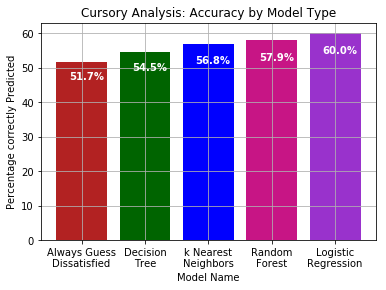

In [101]:
model_scores_list.sort(key= lambda x: x[1])
model_values = [100*value[1] for value in model_scores_list]
model_names = [value[0] for value in model_scores_list]
x_dist = np.linspace(1,len(model_values),num=len(model_values))
fig, ax = plt.subplots()
ax.grid()

bar_width=0.8

plt.bar(x_dist,model_values,width=bar_width,color=colors_for_plots[:len(model_values)])
plt.xticks(x_dist,model_names)
plt.title("Cursory Analysis: Accuracy by Model Type")
plt.xlabel('Model Name')
plt.ylabel('Percentage correctly Predicted')
for ind,score in enumerate(model_values):
    ax.text(x_dist[ind]-.2,score-.1*score,str(score)[:4]+'%',color='white', fontweight='bold')

## Generating Dummy variables
**Requires finnesse**

The cleaned_df dataframe will be used to create the dummy variables

In [62]:
dummies_df = deepcopy(cleaned_df)

In [63]:
# Questions to be turned into variables and corresponding thresholds of original responses to give them a '1' value
dummy_q_and_threshold_list = [
    ('D5', 1), #satisfied with current affairs of country
    ('D9', 2), #country economic condition relatively good
    ('D10', 2), #expect that country economic condition will improve in 10 months
    ('D11', 1), #think children will be better off than them financially
    ('D13A', 2), #believe people are better off in a free market economy
    ('D13B', 2), #believe success in life is determined by forces out of our control
    ('D23A', 2), #believe rising prices in country are a relatively big problem
    ('D23B', 2), #believe lack of employment opportunities in country are a relatively big problem
    ('D23C', 2), #believe gap between rich and poor in country is a relatively big problem
    ('D23D', 2), #believe public debt in country is a relatively big problem
    ('D27', 2), #believe growing trade between their countries and others is a good thing
    ('D28', 1), #believe trade with other countries leads to an increase in wages
    ('D30', 1), #believe trade with other countries leads to increases in price of products sold
    ('D66A', 6), #believe good information is relatively not important to get ahead in life
    ('D66B', 6), #believe working hard is relatively not important to get ahead in life
    ('D66C', 6), #believe knowing the right people is relatively not important to get ahead in life
    ('D66D', 6), #believe giving bribes is relatively not important to get ahead in life
    ('D66E', 6), #believe being male is relatively not important to get ahead in life
    ('D66F', 6), #believe belonging to a wealthy familyis relatively not important to get ahead in life
    ('D66G', 6), #believe being lucky is relatively not important to get ahead in life
    ('D132', 1)] #is a male

In [64]:
#creation of dummy variables
def set_dummy_variable_value(row):
    if row[old_question_variable] <= threshhold_for_1:
        return 1
    else:
        return 0

for ind,new_dummy_variable in enumerate(dummy_q_and_threshold_list):
    old_question_variable = new_dummy_variable[0].replace('D','Q',1)
    threshhold_for_1 = new_dummy_variable[1]
    dummies_df[new_dummy_variable[0]]=dummies_df.apply(set_dummy_variable_value,axis=1)

## A new dataframe with only dummy variables and the response


In [66]:
dummies_df.sample(7,random_state=40)

,Q2agg,Q5,Q9,Q10,Q11,Q13A,Q13B,Q23A,Q23B,Q23C,...,D28,D30,D66A,D66B,D66C,D66D,D66E,D66F,D66G,D132
12921,5.0,2.0,4.0,3.0,2.0,3.0,8.0,1.0,1.0,2.0,...,0,0,0,0,0,1,0,1,0,0
8548,5.0,2.0,4.0,4.0,2.0,8.0,2.0,1.0,1.0,1.0,...,0,0,1,1,0,0,0,1,0,1
23096,8.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1,0,0,0,0,1,0,0,0,1
36439,7.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0,1,0,0,0,1,1,1,1,1
35480,8.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
13613,5.0,2.0,2.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,...,0,1,1,0,1,1,1,1,0,1
47230,4.0,2.0,4.0,5.0,3.0,3.0,2.0,1.0,1.0,1.0,...,1,1,0,0,0,1,1,0,0,1


In [67]:
pure_dummies_with_response = dummies_df.iloc[:,26:]

In [68]:
pure_dummies_with_response.sample(7,random_state=40)

,satisfaction_rating,D5,D9,D10,D11,D13A,D13B,D23A,D23B,D23C,...,D28,D30,D66A,D66B,D66C,D66D,D66E,D66F,D66G,D132
12921,Dissatisfied,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,0
8548,Dissatisfied,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,0,0,1,0,1
23096,Satisfied,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,0,0,0,1
36439,Satisfied,0,0,1,0,1,1,1,1,1,...,0,1,0,0,0,1,1,1,1,1
35480,Satisfied,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13613,Dissatisfied,0,1,0,0,0,1,0,0,0,...,0,1,1,0,1,1,1,1,0,1
47230,Dissatisfied,0,0,0,0,0,1,1,1,1,...,1,1,0,0,0,1,1,0,0,1


In [69]:
X2= pure_dummies_with_response.iloc[:,1:]
y2= pure_dummies_with_response.loc[:,'satisfaction_rating']

In [103]:
model_scores_list_2

[('Always Guess\nDissatisfied', 0.51721869328493641, 0.51721869328493641),
 ('Decision\nTree', 0.55401542649727764, 0.54564428312159707),
 ('Random\nForest', 0.56658348457350283, 0.57960526315789485),
 ('Logistic\nRegression', 0.59500907441016326, 0.60004537205081676),
 ('k Nearest\nNeighbors', 0.56057168784029043, 0.56842105263157894)]

In [102]:
# models with dummy variables modified from original
model_scores_list_2=[]

#The Baseline Dummy Classifier Model - Everyone is dissatisfied
dummyclassifiermodel = DummyClassifier(strategy='most_frequent',random_state=40)
dummy_score_2 = cross_val_score(dummyclassifiermodel,X2,y2,cv=cross_validator).mean()
print(f"Score of DummyClassifier Model = {dummy_score_2}")
model_scores_list_2.append((model_str_dict['dummy'],dummy_score_2,dummy_score))

#Decision Tree Classifier Model
decisiontree = DecisionTreeClassifier(random_state=40)
decisiontree_score_2 = cross_val_score(decisiontree,X2,y2,cv=cross_validator).mean()
print(f"Score of Decision Tree Model = {decisiontree_score_2}")
model_scores_list_2.append((model_str_dict['decision'],decisiontree_score_2,decisiontree_score))

#Random Forest Classifier Model
randomforest = RandomForestClassifier(random_state=40,n_jobs=-1)
randomforest_score_2 = cross_val_score(randomforest,X2,y2,cv=cross_validator).mean()
print(f"Score of Random Forest Model = {randomforest_score_2}")
model_scores_list_2.append((model_str_dict['randomf'],randomforest_score_2,randomforest_score))

#Logistic Regression Classifier Model
logregression = LogisticRegression(random_state=40,n_jobs=-1)
logregression_score_2 = cross_val_score(logregression,X2,y2,cv=cross_validator).mean()
print(f"Score of Logistic Regression Model = {logregression_score_2}")
model_scores_list_2.append((model_str_dict['logr'],logregression_score_2,logregression_score))

#K Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_score_2 = cross_val_score(knn,X2,y2,cv=cross_validator).mean()
print(f"Score of KNN Model = {knn_score_2}")
model_scores_list_2.append((model_str_dict['knn'],knn_score_2,knn_score))

Score of DummyClassifier Model = 0.5172186932849364
Score of Decision Tree Model = 0.5540154264972776
Score of Random Forest Model = 0.5665834845735028
Score of Logistic Regression Model = 0.5950090744101633
Score of KNN Model = 0.5605716878402904


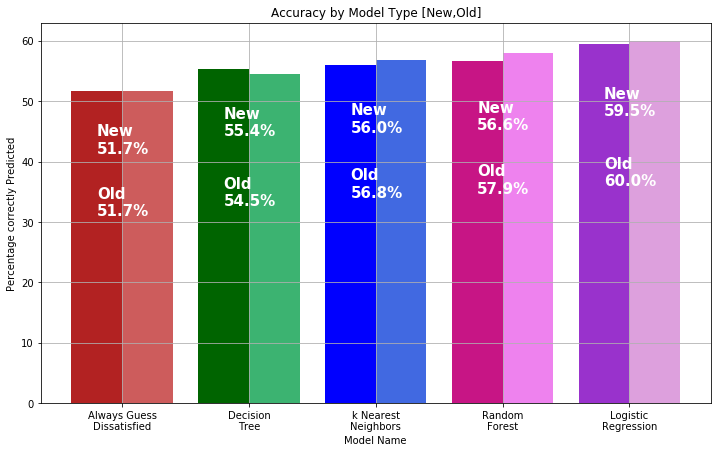

In [129]:
model_scores_list_2.sort(key= lambda x: x[2])
model_values_new = [100*value[1] for value in model_scores_list_2]
model_values_old = [100*value[2] for value in model_scores_list_2]
model_names = [value[0] for value in model_scores_list]

x_dist = 2*np.linspace(1,len(model_values_new),num=len(model_values_new))
fig, ax = plt.subplots(figsize=(12,7))
ax.grid()
bar_width=0.8
text_settings={'color':'white', 'fontweight':'bold','fontsize':15}


plt.bar(x_dist-bar_width/2,model_values_new,width=bar_width,color=colors_for_plots[:len(model_values_new)])
plt.bar(x_dist+bar_width/2,model_values_old,width=bar_width,color=colors_for_plots_2[:len(model_values_old)])

plt.xticks(x_dist,model_names)
plt.title("Accuracy by Model Type [New,Old]")
plt.xlabel('Model Name')
plt.ylabel('Percentage correctly Predicted')
for ind,score in enumerate(model_values_new):
    ax.text(x_dist[ind]-.4,score-.2*score,'New\n'+str(score)[:4]+'%',**text_settings)
for ind,score in enumerate(model_values_old):
    ax.text(x_dist[ind]-.4,score-.4*score,'Old\n'+str(score)[:4]+'%',**text_settings)

**Well, that was unfortunate**

With Dummy variables, all the models performed slightly worse compared to when dummy variables were not involved except for the decision tree.

### Hyperparameter optimization
**This calls for a grid CV to optimize parameters.** Time to bring out the big guns. 

In [151]:
randomforest_grid_params = {'n_jobs':[-1], 'n_estimators':[45],
                             'max_depth':[11,12], 'min_samples_split':[15,18,24],
                             'min_samples_leaf':[24,28,32], 'random_state':[40]}
randomforest_grid_search = GridSearchCV(RandomForestClassifier(),randomforest_grid_params,
                                        n_jobs=-1,cv=cross_validator)

In [152]:
randomforest_grid_search.fit(X2,y2)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_jobs': [-1], 'n_estimators': [45], 'max_depth': [11, 12], 'min_samples_split': [15, 18, 24], 'min_samples_leaf': [24, 28, 32], 'random_state': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [153]:
randomforest_grid_search.best_score_

0.60052177858439204

In [154]:
randomforest_grid_search.best_params_

{'max_depth': 11,
 'min_samples_leaf': 32,
 'min_samples_split': 15,
 'n_estimators': 45,
 'n_jobs': -1,
 'random_state': 40}

In [140]:
randomforest_grid_params = {'n_jobs':[-1], 'n_estimators':[15],
                             'max_depth':[15,20,25], 'min_samples_split':[25,35,45],
                             'min_samples_leaf':[25,35,55], 'random_state':[40]}
randomforest_grid_search = GridSearchCV(RandomForestClassifier(),randomforest_grid_params,
                                        n_jobs=-1,cv=cross_validator)

In [141]:
randomforest_grid_search.fit(X2,y2)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_jobs': [-1], 'n_estimators': [15], 'max_depth': [15, 20, 25], 'min_samples_split': [25, 35, 45], 'min_samples_leaf': [25, 35, 55], 'random_state': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [142]:
randomforest_grid_search.best_score_

0.60018148820326678

In [143]:
randomforest_grid_search.best_params_

{'max_depth': 15,
 'min_samples_leaf': 35,
 'min_samples_split': 25,
 'n_estimators': 15,
 'n_jobs': -1,
 'random_state': 40}

In [184]:
logregression_grid_params = {'n_jobs':[-1], 'penalty':['l1','l2'],
                             'C':np.logspace(-2,-.5,5), 'random_state':[40]}

logregression_grid_search = GridSearchCV(LogisticRegression(),logregression_grid_params,
                                        n_jobs=-1,cv=cross_validator)

In [185]:
logregression_grid_search.fit(X2,y2)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_jobs': [-1], 'penalty': ['l1', 'l2'], 'C': array([ 0.01   ,  0.02371,  0.05623,  0.13335,  0.31623]), 'random_state': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [186]:
logregression_grid_search.best_score_

0.59541742286751365

In [187]:
logregression_grid_search.best_params_

{'C': 0.023713737056616554, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 40}

In [188]:
logregression_grid_search.grid_scores_

/home/farhaan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.59406, std: 0.00663, params: {'C': 0.01, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 40},
 mean: 0.59526, std: 0.00683, params: {'C': 0.01, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 40},
 mean: 0.59542, std: 0.00693, params: {'C': 0.023713737056616554, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 40},
 mean: 0.59535, std: 0.00672, params: {'C': 0.023713737056616554, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 40},
 mean: 0.59515, std: 0.00731, params: {'C': 0.056234132519034911, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 40},
 mean: 0.59521, std: 0.00720, params: {'C': 0.056234132519034911, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 40},
 mean: 0.59501, std: 0.00682, params: {'C': 0.1333521432163324, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 40},
 mean: 0.59517, std: 0.00727, params: {'C': 0.1333521432163324, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 40},
 mean: 0.59521, std: 0.00719, params: {'C': 0.31622776601683794, 'n_jobs': -1, 'penalty': 'l

In [197]:
linearsvc_grid_params = {'C':np.logspace(-2,2,5), 'penalty':['l2'],
                         'loss':['hinge','squared_hinge'],'random_state':[40]}

linearsvc_grid_search = GridSearchCV(LinearSVC(),linearsvc_grid_params,
                                     n_jobs=-1,cv=cross_validator)

In [198]:
linearsvc_grid_search.fit(X2,y2)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'penalty': ['l2'], 'loss': ['hinge', 'squared_hinge'], 'random_state': [40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [199]:
linearsvc_grid_search.best_score_

0.59602994555353905

In [200]:
linearsvc_grid_search.best_params_

{'C': 10.0, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 40}

In [ ]:
print(linearsvc_grid_search.best_score_)
print(linearsvc_grid_search.best_params_)

In [228]:
knn_grid_params = {'n_jobs':-1,'n_neighbors':[15,60,160,300], 'weights':['uniform','distance'],
                         'leaf_size':[25,40,90],'random_state':[40]}

knn_grid_search = GridSearchCV(LinearSVC(),linearsvc_grid_params,
                                     n_jobs=-1,cv=cross_validator)

In [229]:
knn_grid_search.fit(X2,y2)

ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information